In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import json
import requests

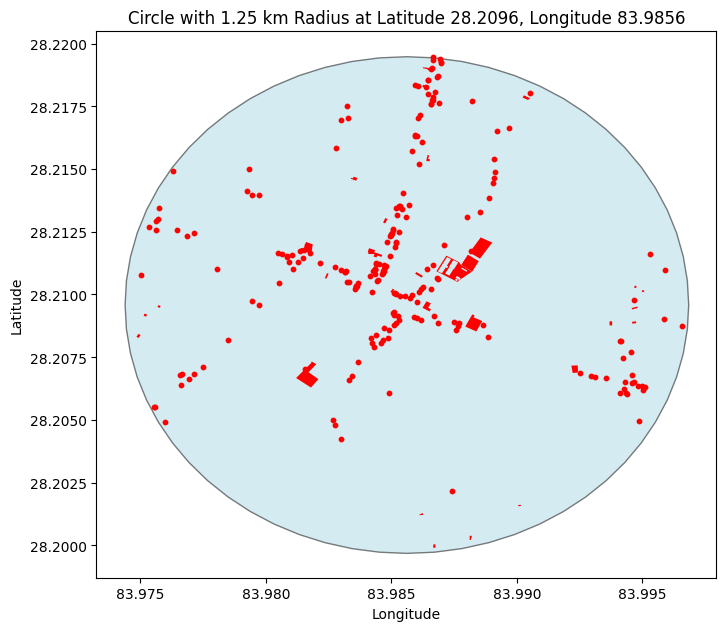

In [ ]:
def create_circle(radius_km=1.25, lat=28.2096, lon=83.9856):
    radius_m = radius_km * 1000
    center = gpd.GeoDataFrame(geometry=gpd.points_from_xy([lon], [lat]), crs="EPSG:4326")
    circle = center.to_crs(epsg=3857).buffer(radius_m).to_crs(epsg=4326)
    return gpd.GeoDataFrame(geometry=circle)

latitude = 28.2096
longitude = 83.9856

circle_gdf = create_circle(radius_km=1.25, lat=latitude, lon=longitude)


fig, ax = plt.subplots(figsize=(8, 8))
circle_gdf.plot(ax=ax, color="lightblue", edgecolor="black", alpha=0.5)

ax.set_title(f"Circle with 1.25 km Radius at Latitude {latitude}, Longitude {longitude}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")


circle_feature_geometry = circle_gdf.__geo_interface__['features'][0]['geometry']

BASE_API_URL = 'https://api-prod.raw-data.hotosm.org/v1'
headers = {'accept': "application/json","Content-Type": "application/json"}
payload_template = {
    "geometry": {
        "type": "Polygon",
        "coordinates": []
    },
    "filters": {
        "tags": {
            "all_geometry": {
                "join_or": {
                    "amenity": ["hospital", "clinic", "doctors", "pharmacy", "police", "fire_station"],
                    "emergency": ["yes"],
                    "highway": ["bus_stop"],
                    "amenity": ["school", "kindergarten", "university"],
                    "shop": ["supermarket", "grocery", "bakery", "convenience"],
                    "amenity": ["bank", "atm"]
                }
            }
        }
    },
    "geometryType": ["point", "polygon"]
}
payload_template['geometry']=circle_feature_geometry
task_response = requests.post(url = f"{BASE_API_URL}/snapshot/plain/", data = json.dumps(payload_template),headers=headers)
task_response.raise_for_status()
result = task_response.json()

try:
    geo_data = gpd.GeoDataFrame.from_features(result['features'])
    geo_data.plot(ax=ax, markersize=10, color='red')
except (KeyError, ValueError) as ex:
    print(f"Could not plot the result: {ex}")


In [ ]:
#print(result)

{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [83.9952927, 28.2116169]}, 'properties': {'osm_id': 4242360799, 'osm_type': 'nodes', 'version': 2, 'tags': {'name': 'Babu Kirana Pasal', 'shop': 'convenience', 'name:ne': 'बाबु किराना पसल'}, 'changeset': 41653023, 'timestamp': '2016-08-24T05:00:16'}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [83.9959078, 28.2109777]}, 'properties': {'osm_id': 4170744674, 'osm_type': 'nodes', 'version': 6, 'tags': {'name': 'Ramghat Women Saving & Credit Cooperative', 'phone': '061-533769', 'amenity': 'bank', 'name:ne': 'राम घाट माहिला वचत तथा क्रेडित सहकारी संस्था', 'nrb_class': 'co-operative', 'addr:place': 'Ram Ghat, Pokhara-10'}, 'changeset': 59936045, 'timestamp': '2018-06-18T09:04:25'}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [83.988901, 28.2138639]}, 'properties': {'osm_id': 4599484431, 'osm_type': 'nodes', 'version': 5, 'tags': {'name': 'Mah

In [ ]:
def analyze_geojson(result):
    if 'features' not in result or not isinstance(result['features'], list):
      print("Invalid GeoJSON data. 'features' key not found or not a list.")
      return

    feature_counts = {
        "education": 0,
        "financial": 0,
        "emergency": 0,
        "convenience": 0
    }

    for feature in result['features']:
        properties = feature.get('properties', {})
        tags = properties.get('tags', {})

        if "amenity" in tags:
            if tags["amenity"] in ["school", "kindergarten", "university", "college"]:
                feature_counts["education"] += 1
            elif tags["amenity"] in ["bank", "atm"]:
                feature_counts["financial"] += 1
            elif tags["amenity"] in ["hospital", "clinic", "doctors", "pharmacy", "police", "fire_station"]:
                feature_counts["emergency"] += 1
            else:
                feature_counts["convenience"] +=1

        elif "emergency" in tags and tags["emergency"] == "yes":
            feature_counts["emergency"] += 1
        elif "shop" in tags and tags["shop"] in ["supermarket", "grocery", "bakery", "convenience"]:
            feature_counts["convenience"] += 1
        else:
            feature_counts["convenience"] += 1

    total_features = sum(feature_counts.values())
    analysis_results = {}

    for feature_type, count in feature_counts.items():
        percentage = (count / total_features) * 100 if total_features > 0 else 0
        analysis_results[feature_type] = {
            "count": count,
            "percentage": percentage
        }

    return analysis_results

In [ ]:
analyze_result=analyze_geojson(result)
print(analyze_result)

{'education': {'count': 0, 'percentage': 0.0}, 'financial': {'count': 137, 'percentage': 54.1501976284585}, 'emergency': {'count': 8, 'percentage': 3.1620553359683794}, 'convenience': {'count': 108, 'percentage': 42.68774703557312}}
